In [1]:
import os
import json

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

from keras import layers
from keras import models
from keras.models import load_model
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

from sklearn.model_selection import StratifiedKFold
import cv2

img_size = (224,224)

2022-06-29 11:03:44.332986: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-29 11:03:44.333661: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def load_image(img_path, show=False):

    img = image.load_img(img_path, target_size=(224, 224))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255
    
    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor

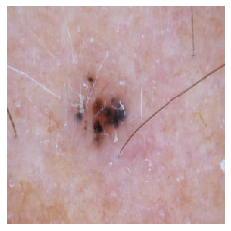

In [3]:
img = load_image("basal1.jpg", True)

## Loading Models

In [4]:
model_end_to_end = load_model('cancer_classification_end_to_end_40.h5')
model_data_augmentation = load_model('cancer_classification_data_augmentation_40.h5')
model_vgg_feature = load_model('cancer_classification_vgg6_25.h5')
model_vgg_fine = load_model('cancer_classification_vgg16_fine_tuning_25.h5')
model_metadata = load_model('cancer_classification_metadata.h5')

2022-06-29 11:05:54.281795: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-29 11:05:54.281958: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-29 11:05:54.281980: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-DH62PHK): /proc/driver/nvidia/version does not exist
2022-06-29 11:05:54.284726: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
models = [model_end_to_end, model_data_augmentation, model_vgg_feature, model_vgg_fine]

## Predicting new images

In [18]:
data = [f"basal{i}.jpg" for i in range(1,8)]
prom = []
for item in data:
    img = load_image(item)
    pred = []
    for m in models:    
        pred.append(m.predict(img)[0][0])  
    print(item,": ",pred)    
    prom.append(np.mean(pred))
print(prom)


basal1.jpg :  [1.1972992e-05, 0.17488104, 0.36767352, 0.0001154699]
basal2.jpg :  [0.5778084, 0.48190022, 0.19711423, 0.12366536]
basal3.jpg :  [0.72345245, 0.37801117, 0.6055383, 0.50023705]
basal4.jpg :  [0.029274166, 0.5172338, 0.6294674, 0.21289638]
basal5.jpg :  [0.97499704, 0.0610331, 0.0045019686, 0.0]
basal6.jpg :  [0.15642095, 0.7588097, 0.13517606, 0.0018499792]
basal7.jpg :  [2.8512013e-16, 8.777924e-10, 1.8531262e-07, 1.5771293e-19]
[0.1356705, 0.34512204, 0.5518097, 0.34721792, 0.26013303, 0.26306418, 4.65476e-08]


In [19]:
data = [f"espino{i}.jpg" for i in range(1,8)]
prom = []
for item in data:
    img = load_image(item)
    pred = []
    for m in models:    
        pred.append(m.predict(img)[0][0])  
    print(item,": ",pred)    
    prom.append(np.mean(pred))
print(prom)

espino1.jpg :  [0.3308309, 0.38804668, 0.1652602, 0.38704854]
espino2.jpg :  [0.6984146, 0.16001591, 0.64237756, 0.99823296]
espino3.jpg :  [1.0, 0.889137, 0.49031094, 0.87695676]
espino4.jpg :  [0.017093182, 0.10344568, 0.51201946, 0.032613575]
espino5.jpg :  [0.9996014, 0.8977318, 0.4864987, 0.82728016]
espino6.jpg :  [0.94697475, 0.12294784, 0.8231915, 0.92899454]
espino7.jpg :  [1.3337401e-05, 0.49155763, 0.7455827, 0.013523787]
[0.3177966, 0.62476027, 0.81410116, 0.16629298, 0.802778, 0.7055272, 0.31266937]


## Heatmaps of class activation

In [20]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import load_model

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

model_builder = keras.applications.xception.Xception
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

In [30]:
img = load_image("basal7.jpg")
model = model_vgg_fine
preds = model.predict(img)
output = model_vgg_fine.output
last_conv_layer = model.get_layer('vgg16').get_layer("block5_conv3")
last_conv_layer_name = "block5_conv3"

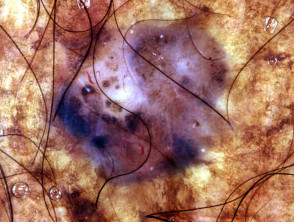

In [31]:
# The local path to our target image
img_path = "basal7.jpg"
display(Image(img_path))

In [32]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [33]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)



In [34]:
def save_and_show_heatmap(img_src_path, img_dst_path, model):
    # Prepare image
    img_array = load_image(img_src_path)

    # Remove last layer's softmax
    model.layers[-1].activation = None

    # Print what the top predicted class is
    preds = model.predict(img_array)
    print("Predicted:", preds)

    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(img_array, model.get_layer("vgg16"), last_conv_layer_name, pred_index = 1)
    
    # Show joined heatmap and image
    save_and_display_gradcam(img_src_path, heatmap, img_dst_path)
    
    # Display Grad CAM
    
    display(Image(img_src_path))
    plt.matshow(heatmap)
    plt.show()
    display(Image(img_dst_path))


Predicted: [[1.5771293e-19]]


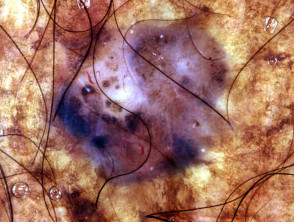

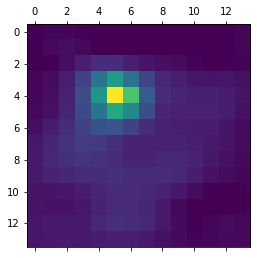

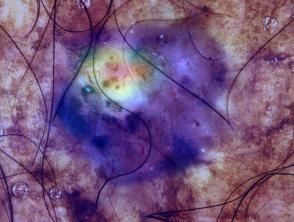

In [35]:
save_and_show_heatmap("basal7.jpg","cam.jpg", model)

Predicted: [[0.50023705]]


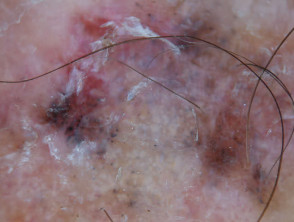

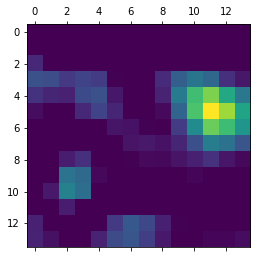

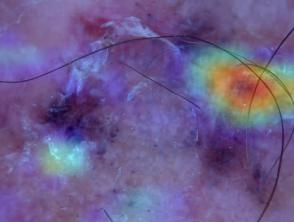

In [36]:
save_and_show_heatmap("basal3.jpg","cam.jpg", model)

Predicted: [[0.99823296]]


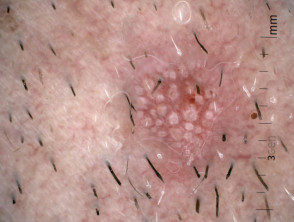

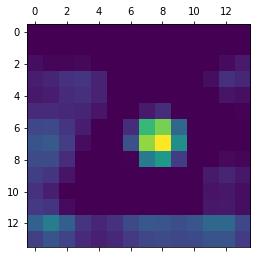

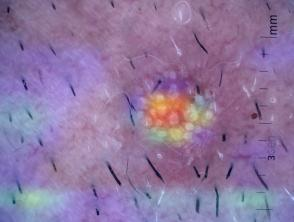

In [43]:
save_and_show_heatmap("espino2.jpg","cam.jpg", model_vgg_fine)

Predicted: [[0.03261358]]


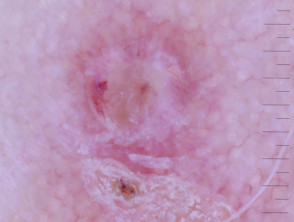

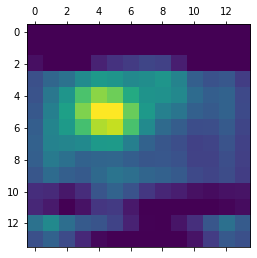

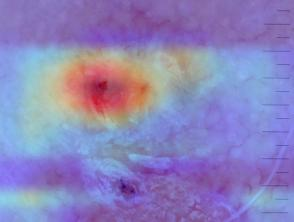

In [44]:
save_and_show_heatmap("espino4.jpg","cam.jpg", model_vgg_fine)

In [241]:
def plot_graphs(history, smooth = False):
    
    def smooth_curve(points, factor=0.8):
        smoothed_points = []
        for point in points:
            if smoothed_points:
                previous = smoothed_points[-1]
                smoothed_points.append(previous * factor + point * (1 - factor))
            else:
                smoothed_points.append(point)
        return smoothed_points
   
    acc = smooth_curve(history['acc']) if smooth else history['acc']
    val_acc = smooth_curve(history['val_acc']) if smooth else history['val_acc']
    loss = smooth_curve(history['loss']) if smooth else history['loss']
    val_loss = smooth_curve(history['val_loss']) if smooth else history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [251]:
with open('cancer_classification_vgg6_20_history.json') as f:
    data = json.load(f)
    plot_graphs(data)

FileNotFoundError: [Errno 2] No such file or directory: 'cancer_classification_vgg6_20_history.json'